In [ ]:
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from PIL import Image

## Get the data
This data comes from a Pew Research survey from April 2020. Respondents were asked to rank their approval for Biden and Trump on a scale of 0-100. I have added a little noise to make the data continuous.

In [ ]:
df = pd.read_csv('https://www.dropbox.com/s/s75wr4iibldupat/American_Political_Approval_April_2020.csv?dl=1', index_col=0)
df['PARTY_LEANING'] = df['PARTY_LEANING'].astype('category')

## Inspect the data
The approval ratings are between **0.0** and **1.0**. Each row represents one survey response. Party leaning of 0 means we do not know the party leaning. Party leaning of **1 == republican** and **2 == democrat**.

In [ ]:
df.head(n=30)

DONALD_APPROVAL  BIDEN_APPROVAL PARTY_LEANING
0          0.000333        0.586027           0.0
1          0.958454        0.044041           0.0
2          0.960416        0.136581           0.0
3          0.516474        0.573252           0.0
4          0.967048        0.016723           0.0
5          0.959240        0.021709           0.0
6          0.007225        0.825582           0.0
7          0.006753        0.711787           0.0
8          0.041506        0.517749           0.0
9          0.045468        0.744164           0.0
10         0.051734        0.530081           0.0
11         0.032105        0.903301           0.0
12         0.121101        0.791558           0.0
13         0.004119        0.798589           0.0
14         0.036657        0.737903           0.0
15         0.864888        0.023578           0.0
16         0.994503        0.016442           0.0
17         0.078417        0.647523           0.0
18         0.002959        0.700527           0.0
19         0.030165        0.051037           0.0
20         0.002726        0.953951           0.0
21         0.132349        0.944375           0.0
22         0.012836        0.832064           0.0
23         0.891402        0.158148           0.0
24         0.033041        0.954287           0.0
25         0.085468        0.761056           0.0
26         0.010766        0.897507           0.0
27         0.917919        0.090864           0.0
28         0.878784        0.026175           0.0
29         0.014661        0.873698           2.0

In [ ]:
df.describe(include='all')

DONALD_APPROVAL  BIDEN_APPROVAL  PARTY_LEANING
count       4788.000000     4788.000000         4788.0
unique              NaN             NaN            3.0
top                 NaN             NaN            0.0
freq                NaN             NaN         4562.0
mean           0.377199        0.468684            NaN
std            0.381033        0.313040            NaN
min            0.000093        0.000114            NaN
25%            0.029719        0.136756            NaN
50%            0.174327        0.497642            NaN
75%            0.785208        0.744787            NaN
max            0.999936        0.999495            NaN

Note below that we have party leaning for about 5% of the respondents. The purple circles below represent democrat-leaning people, and the orange circles represent republican-leaning people. We will use this information for the semi-supervised task.

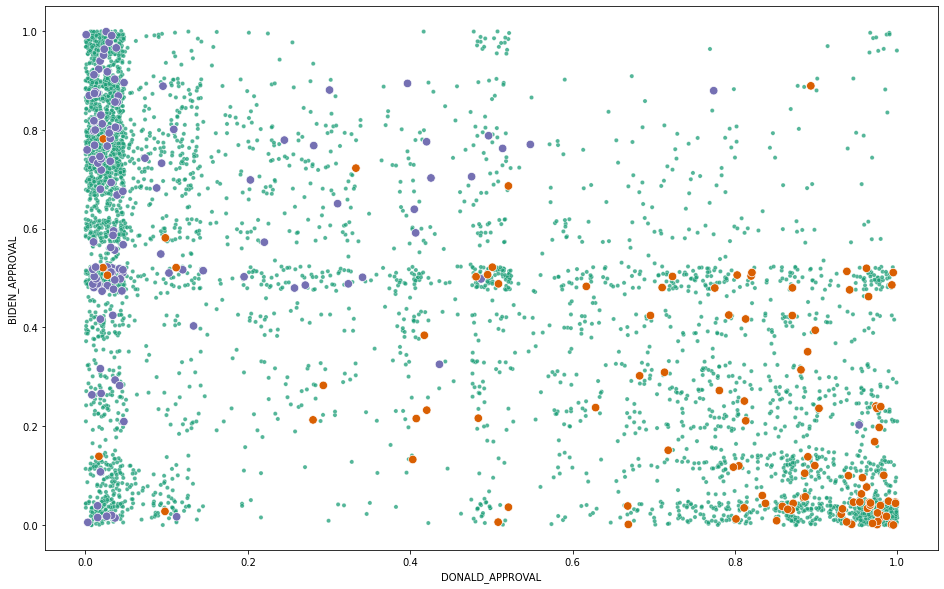

In [ ]:
sns.set_palette('Dark2')
plt.figure(figsize=(16, 10))
size = ((df['PARTY_LEANING'] != 0) * 19 + 1)
ax = sns.scatterplot(x='DONALD_APPROVAL', y='BIDEN_APPROVAL', hue='PARTY_LEANING', data=df[df['PARTY_LEANING'] == 0],
                     size=size, legend=False, alpha=0.75)
sns.scatterplot(x='DONALD_APPROVAL', y='BIDEN_APPROVAL', hue='PARTY_LEANING', data=df[df['PARTY_LEANING'] != 0],
                size=size, legend=False, alpha=1, ax=ax)

## Create the K-Means Unsupervised Model

In [ ]:
def fit_kmeans(x, num_clusters=2, num_fits=100):

    # preparation
    x = x.values
    x_indices = np.arange(x.shape[0])
    best_loss, best_centroids = np.inf, None

    # run the training process `num_fits` times to find the best centroids (k-means has local optima)
    for fit in range(num_fits):

        ########################################################################
        # K-MEANS ALGORITHM PROPER
        ########################################################################

        # randomly initiate starting centroids
        centroid_indicies = np.random.choice(x_indices, 2, replace=False)
        centroids = x[centroid_indicies]
        loss, last_loss = 1e15, np.inf

        # run the algorithm until convergence on this fit
        while loss < last_loss:

            last_loss = loss

            # set the cluster for each sample (E[xpectation] step: fix centroids, estimate sample classes)
            distances = np.zeros((x.shape[0], num_clusters))
            for j, centroid in enumerate(centroids):
                distance = np.sum(np.power(x - centroid, 2), axis=1)
                distances[:, j] = distance

            predicted_clusters = np.argmin(distances, axis=1)
            
            # find the loss and evaluate for convergence
            loss = np.sum(np.power(np.min(distances, axis=1), 2))

            # set the cluster centroids (M[aximization, or here minimization] step: fix sample classes, estimate centroids)
            new_centroids = np.zeros_like(centroids)
            for j, centroid in enumerate(centroids):
                mean = np.mean(x[predicted_clusters == j], axis=0)
                new_centroids[j] = mean
            
            # replace best_centroids with these centroids
            centroids = new_centroids
        
        ########################################################################
        # END OF K-MEANS ALGORITHM PROPER
        ########################################################################
        
        if loss < best_loss:
            best_loss = loss
            best_centroids = centroids.copy()
            print(f'fit {fit}, new best loss:', best_loss)

    return best_centroids

In [ ]:
a = np.array([[1,2], [4,3], [5,6]])
np.min(a, axis=1)

array([1, 3, 5])

## Test and plot

In [ ]:
def predict(x, centroids):

    # assign a cluster int to each sample
    x = x.values
    distances = np.zeros((x.shape[0], centroids.shape[0]))
    for j, centroid in enumerate(centroids):
        distance = np.sum(np.power(x - centroid, 2), axis=1)
        distances[:, j] = distance

    predicted_clusters = np.argmin(distances, axis=1)


    return predicted_clusters

fit 0, new best loss: 68.99317689481217
fit 2, new best loss: 68.98558847082717
fit 4, new best loss: 68.93655865977243
fit 11, new best loss: 68.7036483596354
fit 14, new best loss: 68.4688731141208


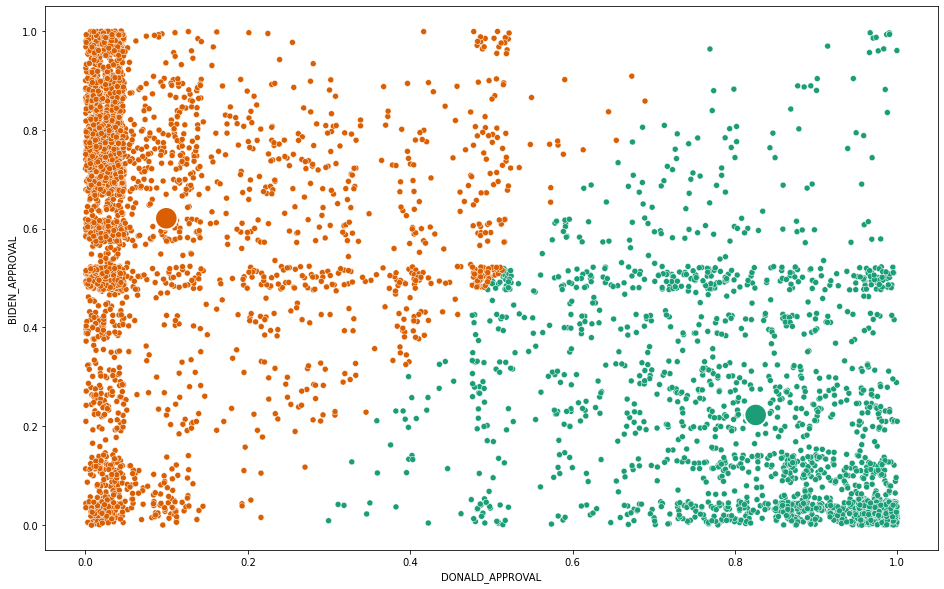

In [ ]:
plt.figure(figsize=(16, 10))
test_df = df[['DONALD_APPROVAL', 'BIDEN_APPROVAL']]
centroids = fit_kmeans(test_df, num_clusters=2, num_fits=500)
test_df['predictions'] = predict(test_df, centroids)
ax = sns.scatterplot(x='DONALD_APPROVAL', y='BIDEN_APPROVAL', hue='predictions', data=test_df,
                legend=False)
sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1], hue=[0, 1], s=500, legend=False, ax=ax)
plt.show()

## Create the K-Means Semi-Supervised Model

In [ ]:
def fit_kmeans_semi(x, labels, alpha=25, num_clusters=2, num_fits=100):

    # preparation
    x = x.values
    x_indices = np.arange(x.shape[0])
    best_loss, best_centroids = np.inf, None

    # run the training process `num_fits` times to find the best centroids (k-means has local optima)
    for fit in range(num_fits):

        ########################################################################
        # K-MEANS ALGORITHM PROPER
        ########################################################################

        # randomly initiate starting centroids
        centroid_indicies = np.random.choice(x_indices, 2, replace=False)
        centroids = x[centroid_indicies]
        loss, last_loss = 1e15, np.inf

        # run the algorithm until convergence on this fit
        while loss < last_loss:

            last_loss = loss

            # set the cluster for each sample (E[xpectation] step: fix centroids, estimate sample classes)
            distances = np.zeros((x.shape[0], num_clusters))
            for j, centroid in enumerate(centroids):
                distance = np.sum(np.power(x - centroid, 2), axis=1)
                distances[:, j] = distance

            predicted_clusters = np.argmin(distances, axis=1)
            for i, sample in enumerate(x):
                predicted_clusters[i] == labels[i] if labels[i] > 0 else predicted_clusters[i]
                distances[i] *= alpha

            # find the loss and evaluate for convergence
            loss = np.sum(np.power(np.min(distances, axis=1), 2))

            # set the cluster centroids (M[aximization, or here minimization] step: fix sample classes, estimate centroids)
            new_centroids = np.zeros_like(centroids)
            for j, centroid in enumerate(centroids):
                mean = np.mean(x[predicted_clusters == j], axis=0)
                new_centroids[j] = mean
            
            # replace best_centroids with these centroids
            centroids = new_centroids
        
        ########################################################################
        # END OF K-MEANS ALGORITHM PROPER
        ########################################################################
        
        if loss < best_loss:
            best_loss = loss
            best_centroids = centroids.copy()
            print(f'fit {fit}, new best loss:', best_loss)

    return best_centroids

## Test and plot

fit 0, new best loss: 43112.98418759261
fit 2, new best loss: 43085.34916235777
fit 3, new best loss: 43056.000346933535
fit 12, new best loss: 43017.73583595199
fit 45, new best loss: 42993.5035557301
fit 114, new best loss: 42925.1442100184
fit 141, new best loss: 42839.71482348506
fit 389, new best loss: 42832.26139402286


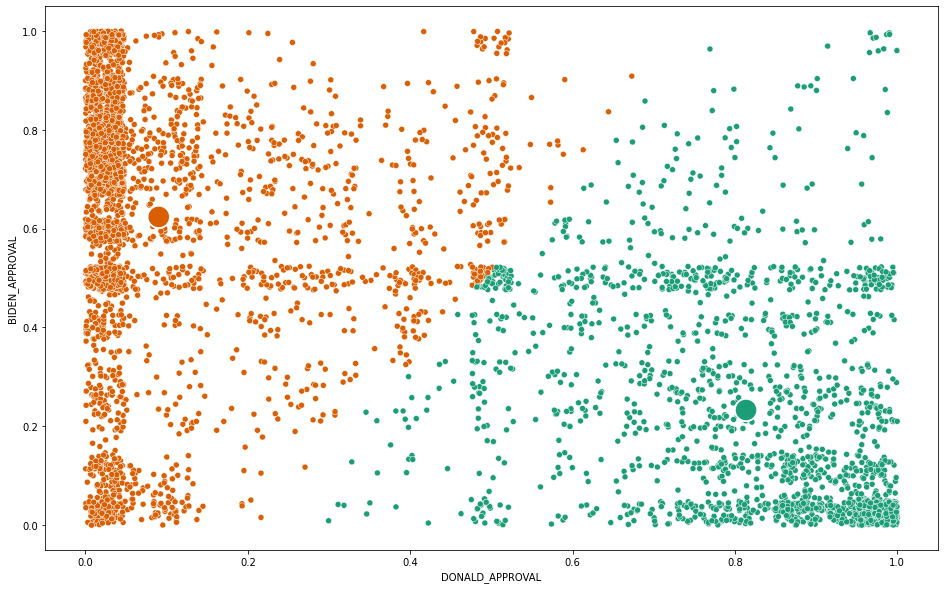

In [ ]:
plt.figure(figsize=(16, 10))
test_df = df[['DONALD_APPROVAL', 'BIDEN_APPROVAL']]
centroids = fit_kmeans_semi(test_df, df['PARTY_LEANING'].astype(int).tolist(), alpha=25, num_clusters=2, num_fits=500)
test_df['predictions'] = predict(test_df, centroids)
ax = sns.scatterplot(x='DONALD_APPROVAL', y='BIDEN_APPROVAL', hue='predictions', data=test_df,
                legend=False)
sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1], hue=[0, 1], s=500, legend=False, ax=ax)
plt.show()

## Compare the above plots to the supervised distribution

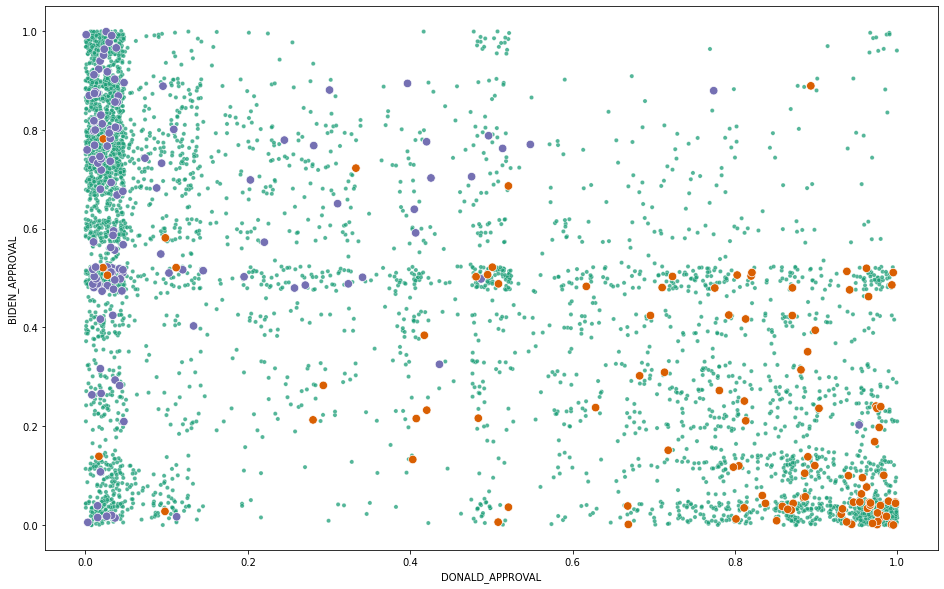

In [ ]:
sns.set_palette('Dark2')
plt.figure(figsize=(16, 10))
size = ((df['PARTY_LEANING'] != 0) * 19 + 1)
ax = sns.scatterplot(x='DONALD_APPROVAL', y='BIDEN_APPROVAL', hue='PARTY_LEANING', data=df[df['PARTY_LEANING'] == 0],
                     size=size, legend=False, alpha=0.75)
sns.scatterplot(x='DONALD_APPROVAL', y='BIDEN_APPROVAL', hue='PARTY_LEANING', data=df[df['PARTY_LEANING'] != 0],
                size=size, legend=False, alpha=1, ax=ax)

## Can you use unsupervised K-Means to reduce an image to 8 colors?

### Get the image and convert to numpy array

In [ ]:
response = requests.get('https://images.pexels.com/photos/1450082/pexels-photo-1450082.jpeg?auto=compress&cs=tinysrgb&dpr=3&h=750&w=1260', stream=True)
image = Image.open(response.raw)

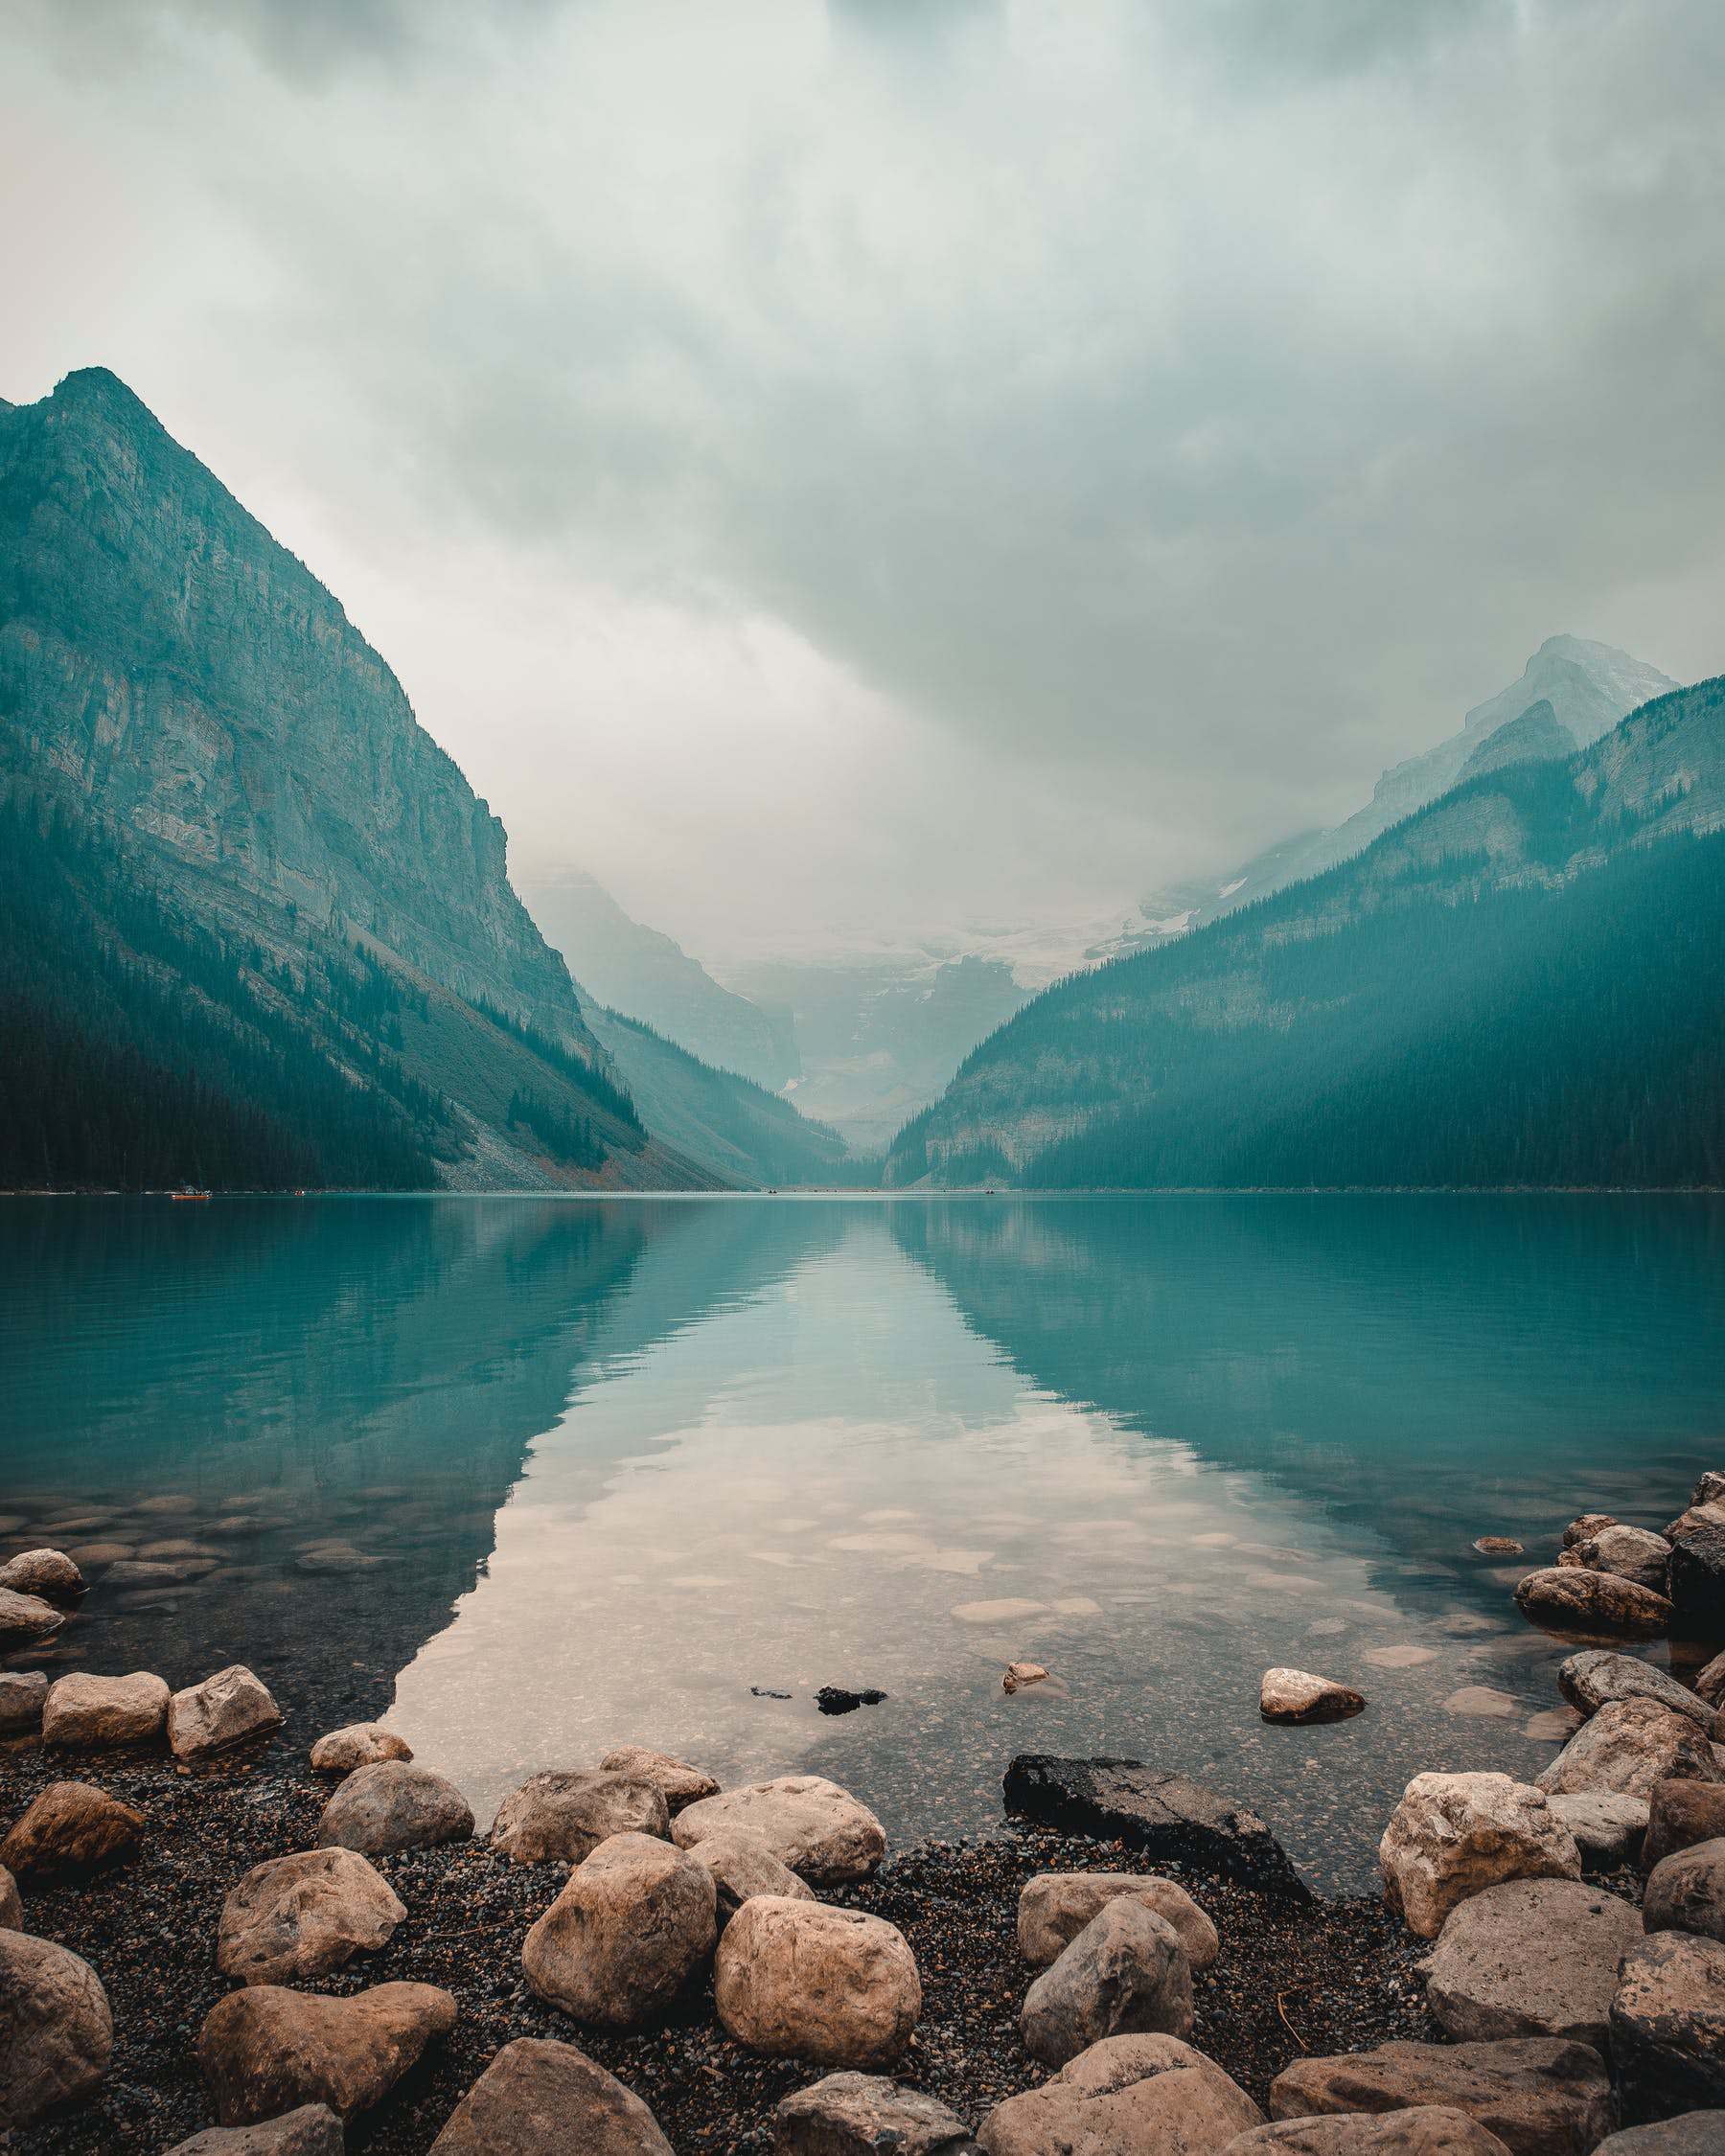

In [ ]:
image

In [ ]:
image_array = np.array(image)
samples = image_array.reshape(-1, 3)
image_array.shape

### Find cluster centers

In [ ]:
cluster_centers = None

### Replace every RGB with nearest cluster center

In [ ]:
new_image_array = None

### Display the new image

In [ ]:
Image.fromarray(new_image_array)